In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install np_utils

In [2]:
%%time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

#____________________________________________________________

import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

#____________________________________________________________

from tqdm.notebook import tqdm
from termcolor import colored
#import albumentations as A

#____________________________________________________________

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)
directory = "../data/"

#____________________________________________________________

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...
CPU times: total: 3.97 s
Wall time: 17.7 s


### Check GPU

In [3]:
print(tensorflow.config.list_physical_devices("GPU"))

print("________________________________________________")

print(tensorflow.test.is_gpu_available(cuda_only = False, min_cuda_compute_capability = None))

[]
________________________________________________
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [4]:
print("Current tensorflow version == {}".format(tensorflow. __version__))

Current tensorflow version == 2.16.1


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Load the datasets 🔺️</p>

In [5]:
%%time

train_df = glob.glob("data/train/**/*.jpeg")
test_df = glob.glob("data/test/**/*.jpeg")
validation_df = glob.glob("data/val/**/*.jpeg")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

The datasets were succesfully loaded...
CPU times: total: 46.9 ms
Wall time: 64 ms


#### <span style='background:#4A1810;color:#ffffff;'> Look at train and test sets </span>

In [6]:
train_df[:5], test_df[:5]

(['data/train\\NORMAL\\IM-0115-0001.jpeg',
  'data/train\\NORMAL\\IM-0117-0001.jpeg',
  'data/train\\NORMAL\\IM-0119-0001.jpeg',
  'data/train\\NORMAL\\IM-0122-0001.jpeg',
  'data/train\\NORMAL\\IM-0125-0001.jpeg'],
 ['data/test\\NORMAL\\IM-0001-0001.jpeg',
  'data/test\\NORMAL\\IM-0003-0001.jpeg',
  'data/test\\NORMAL\\IM-0005-0001.jpeg',
  'data/test\\NORMAL\\IM-0006-0001.jpeg',
  'data/test\\NORMAL\\IM-0007-0001.jpeg'])

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Do some data exploration 🔺️</p>

#### <span style='background:#4A1810;color:#ffffff;'> How many images are in each dataset? </span>

In [7]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5216 images in the training dataset
There is 624 images in the test dataset
There is 16 images in the validation dataset


#### <span style='background:#4A1810;color:#ffffff;'> How many of the pictures are of pneumonic lungs and how many are of normal lungs </span>

In [8]:
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []
directory = "data/"
for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 4273
The number of non-pneumonia images is 1583


#### <span style='background:#4A1810;color:#ffffff;'> Shuffle the images </span>

In [9]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
images[:10]

['data/test\\NORMAL\\NORMAL2-IM-0246-0001-0002.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-0429-0001.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-0818-0001.jpeg',
 'data/train\\NORMAL\\IM-0618-0001-0001.jpeg',
 'data/test\\NORMAL\\NORMAL2-IM-0360-0001.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-1258-0001-0001.jpeg',
 'data/train\\NORMAL\\IM-0523-0001-0002.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-0390-0001.jpeg',
 'data/train\\NORMAL\\IM-0750-0001.jpeg',
 'data/train\\NORMAL\\IM-0678-0001.jpeg']

#### <span style='background:#4A1810;color:#ffffff;'> View the images in X-ray format </span>

<mark>X-ray imaging creates pictures of the inside of a body. The images show the parts of a body in different shades of black and white. This is because different tissues absorb different amounts of radiation. Calcium in bones absorbs x-rays the most, so bones look white</mark>

NORMAL


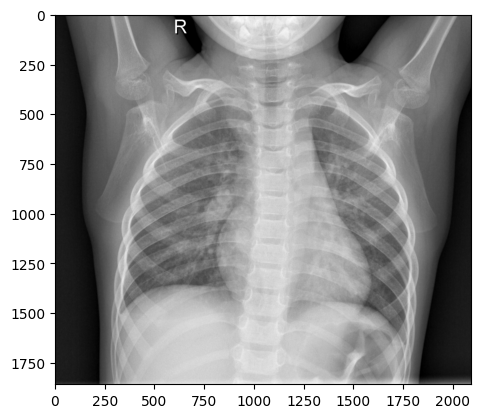

In [10]:
normal_lung_image = load_img("data/train/NORMAL/IM-0115-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

PNEUMONIA


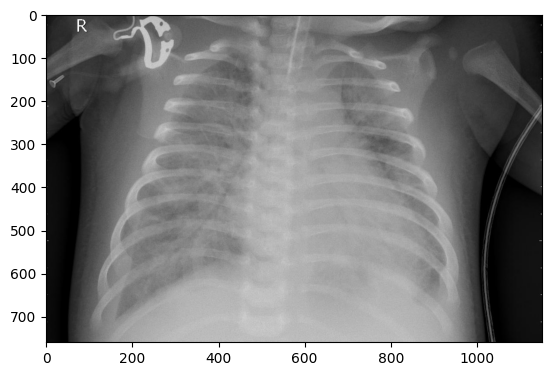

In [11]:
normal_lung_image = load_img("data/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
print("PNEUMONIA")
plt.imshow(normal_lung_image)
plt.show()

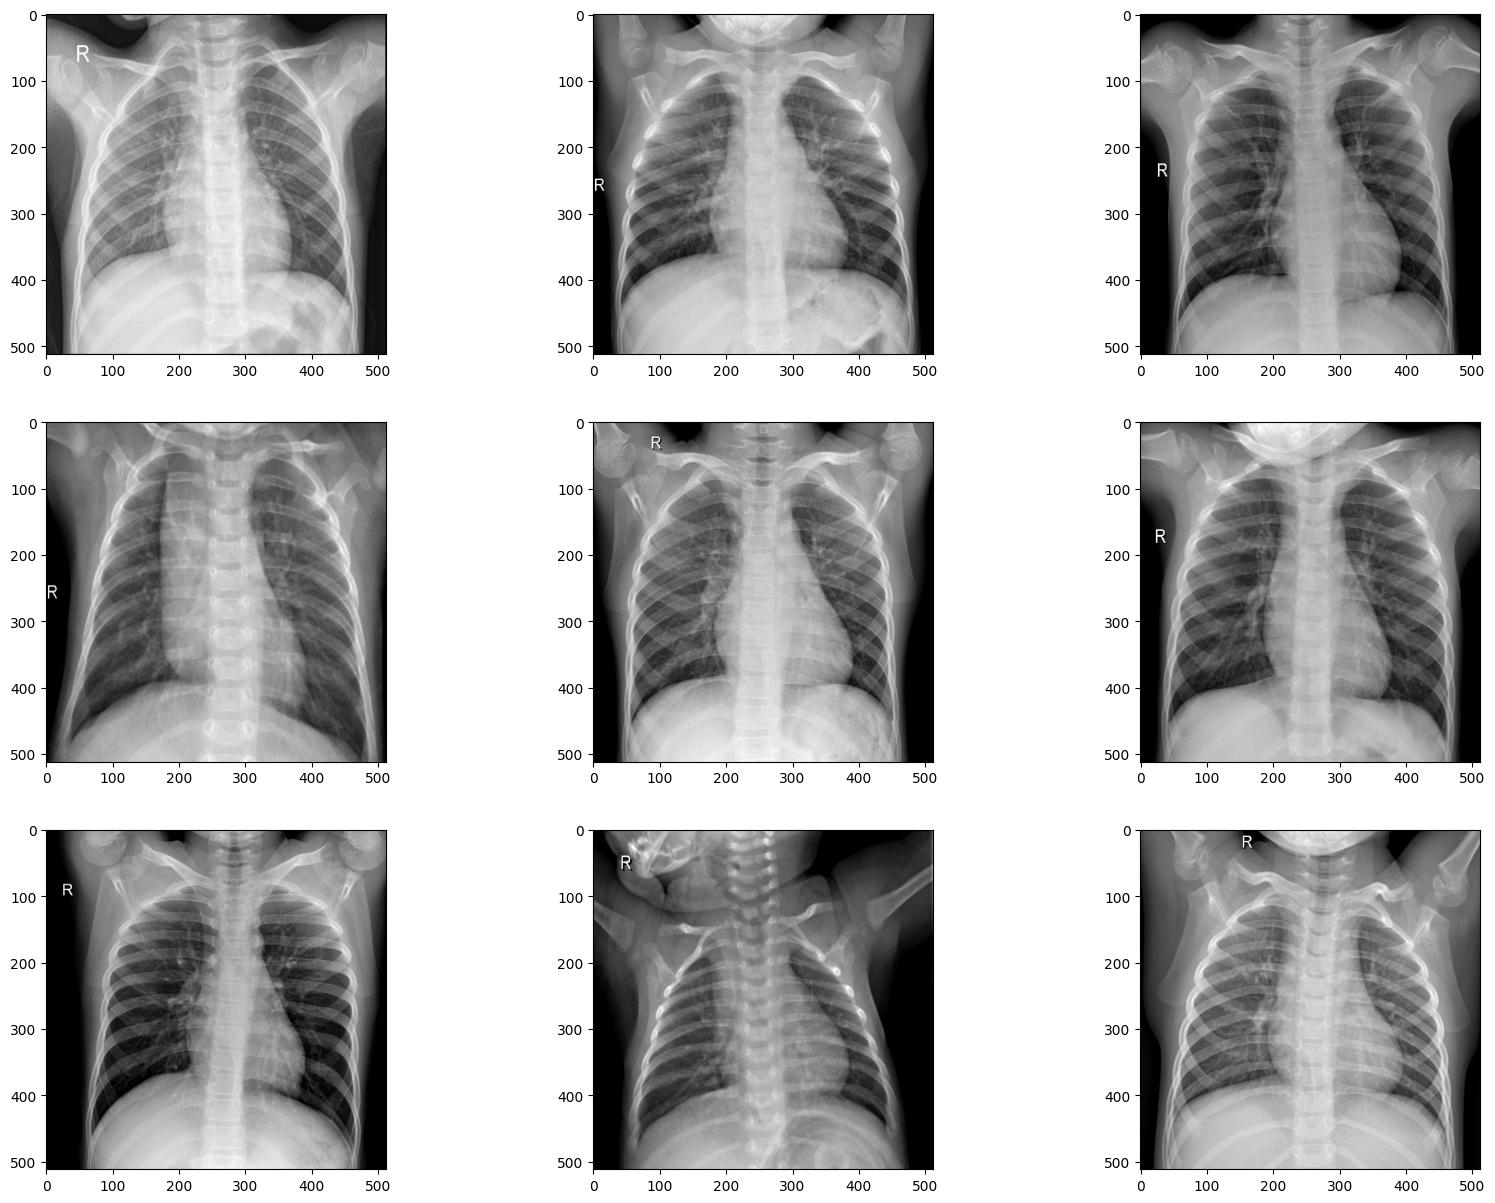

In [12]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

#### <span style='background:#4A1810;color:#ffffff;'> Image erosion </span>

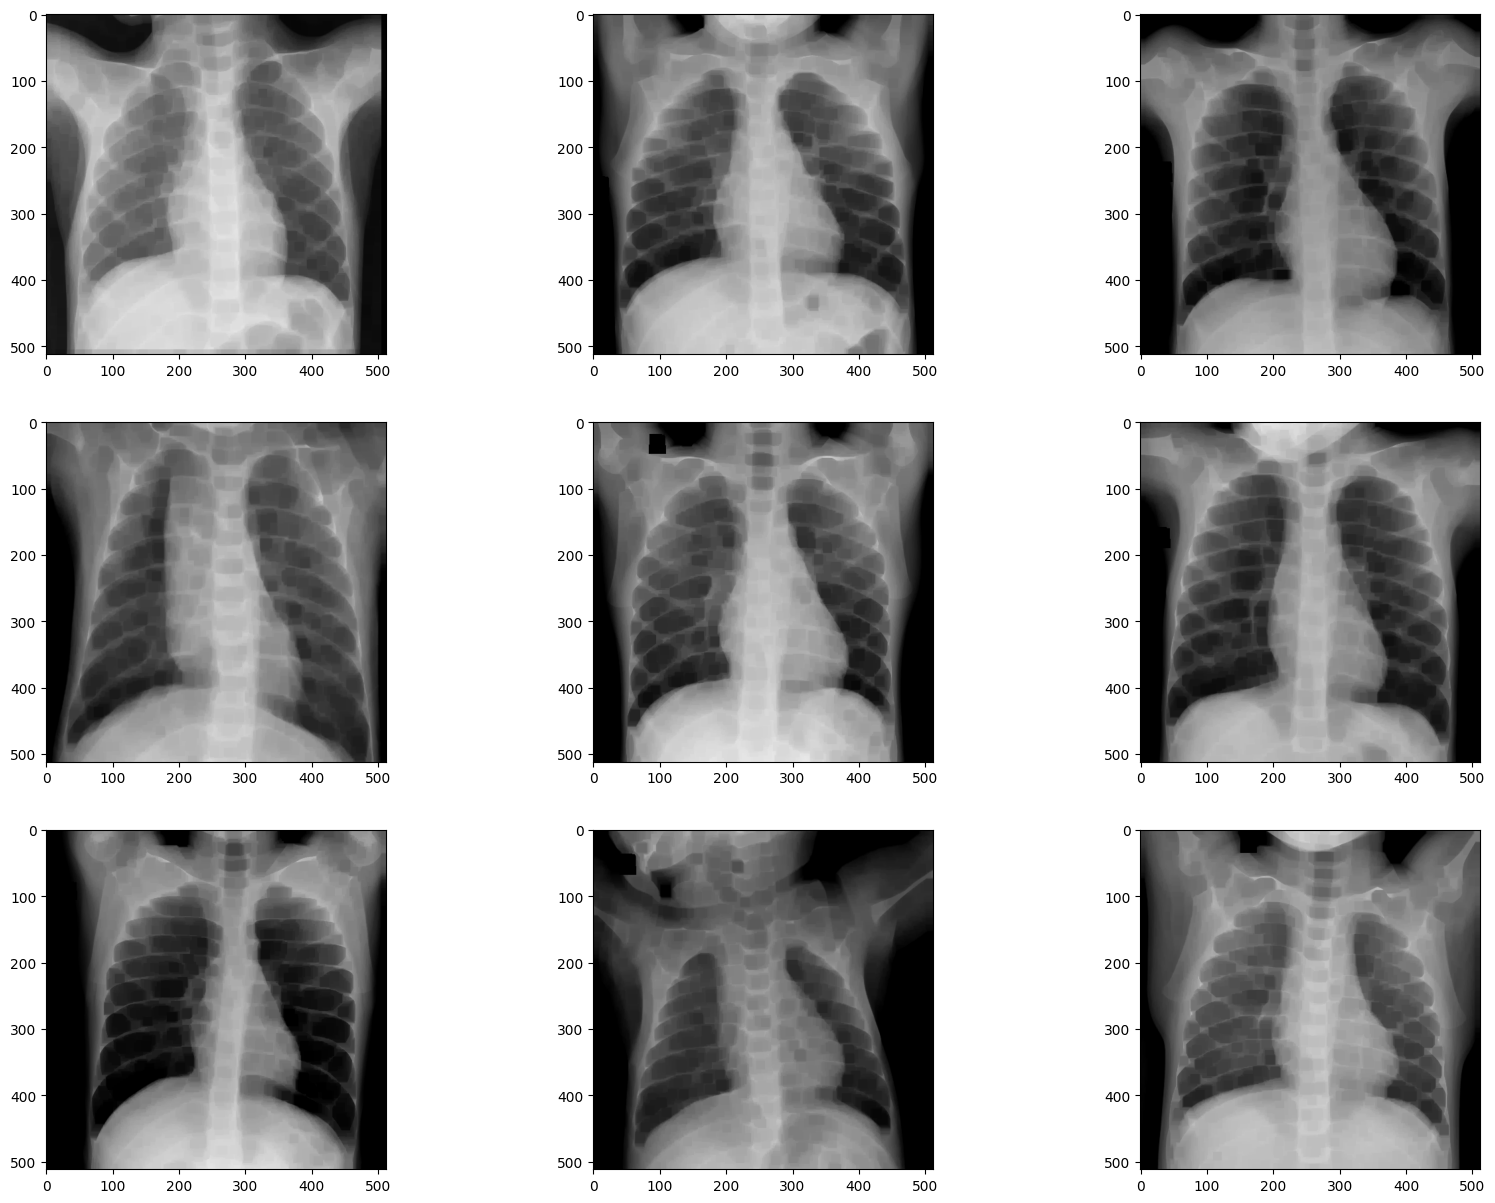

In [13]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

#### <span style='background:#4A1810;color:#ffffff;'> Image dilation </span>

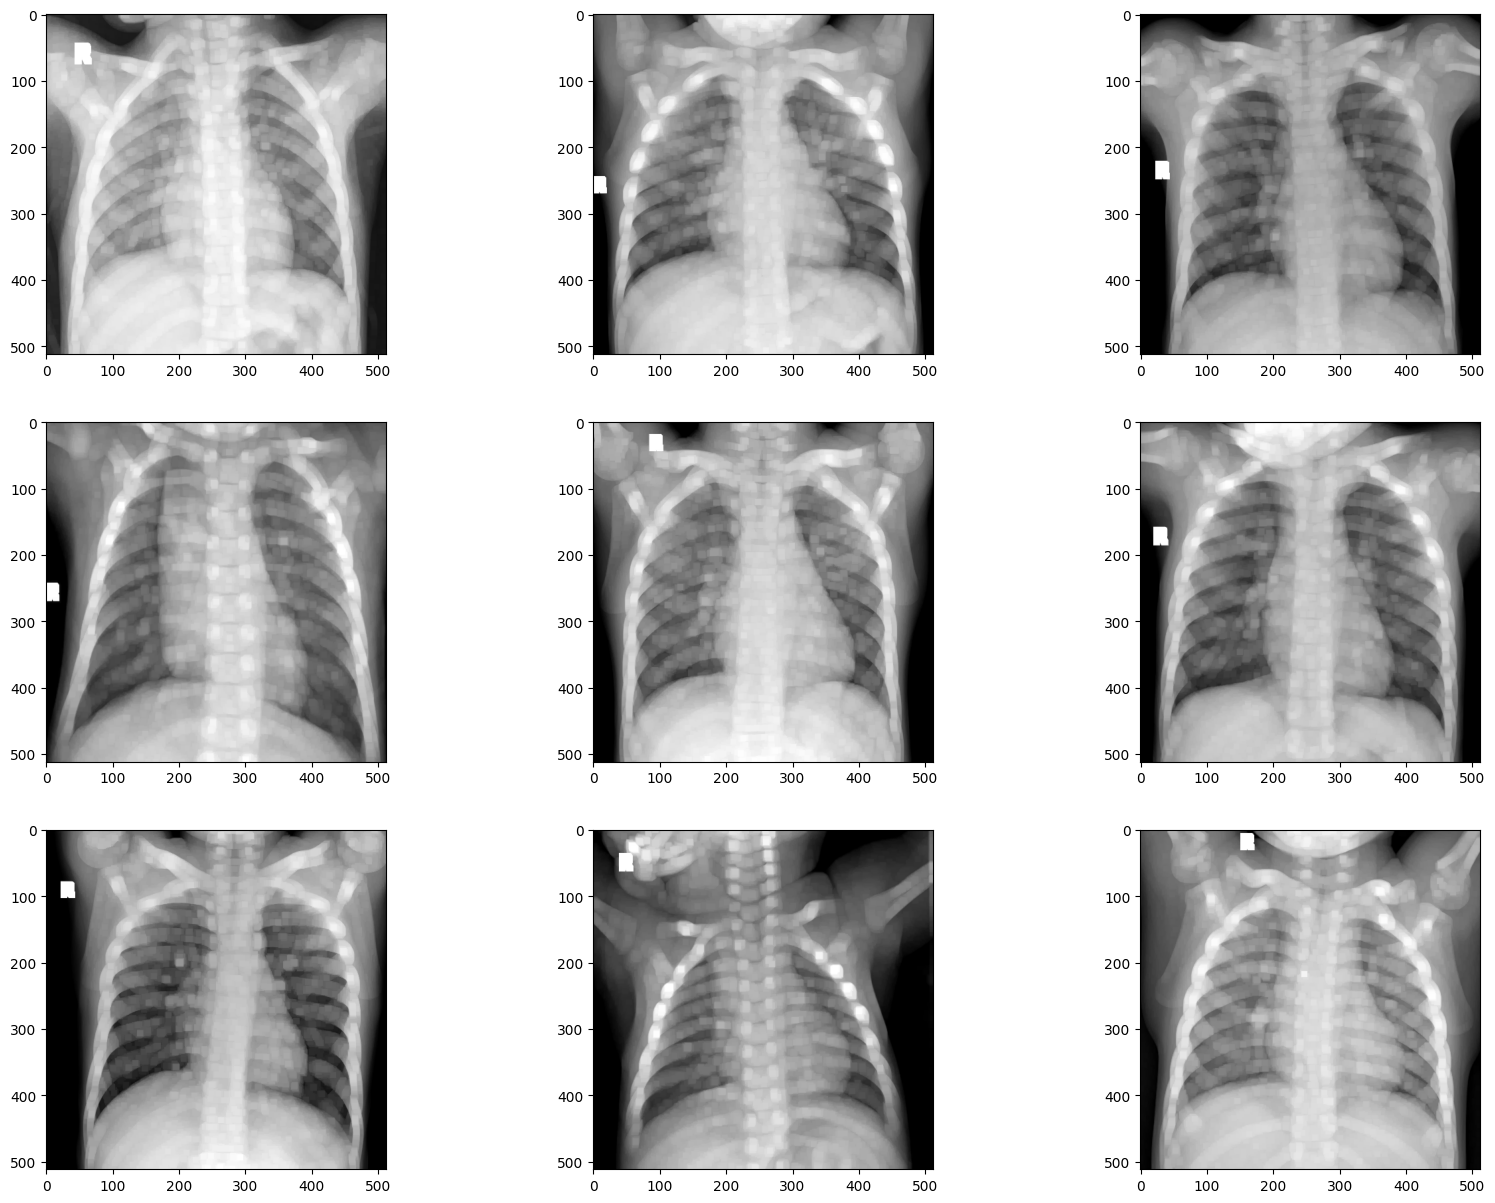

In [14]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_dilation = cv2.dilate(img, kernel, iterations = 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_dilation)

#### <span style='background:#4A1810;color:#ffffff;'> Convert the images to greyscale and then apply Gaussian blur to them </span>

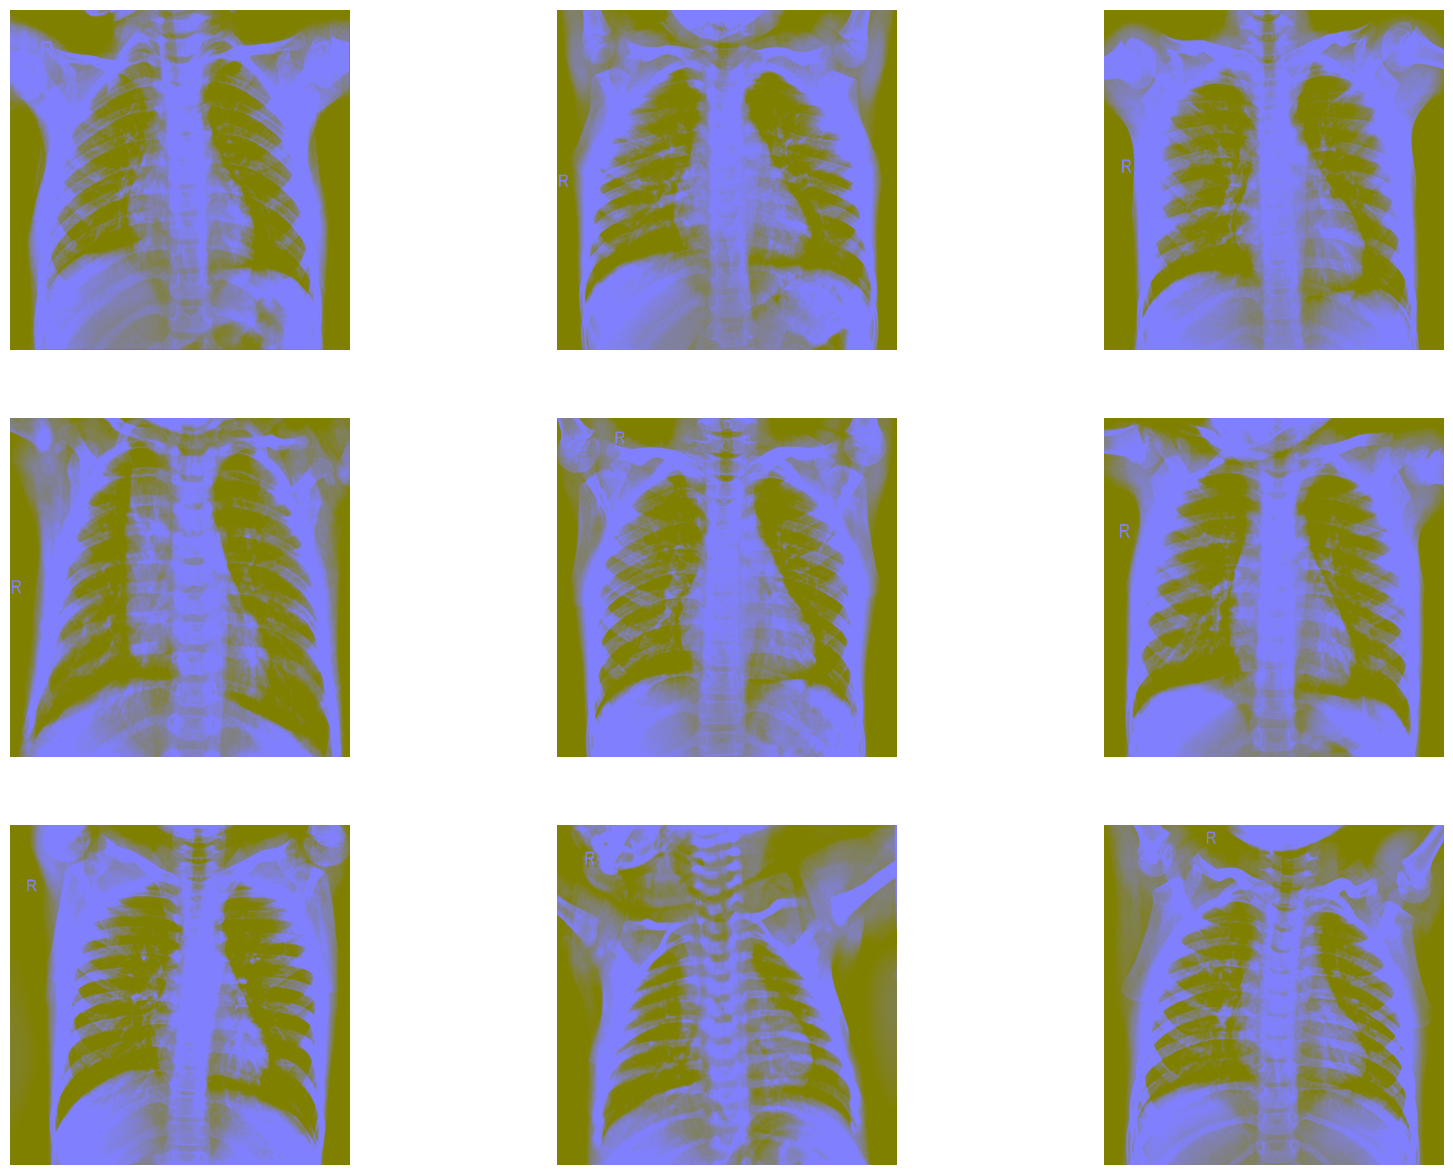

In [15]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

#### <span style='background:#4A1810;color:#ffffff;'> Canny edge detection: </span>

<mark>Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed. It has been widely applied in various computer vision systems</mark>

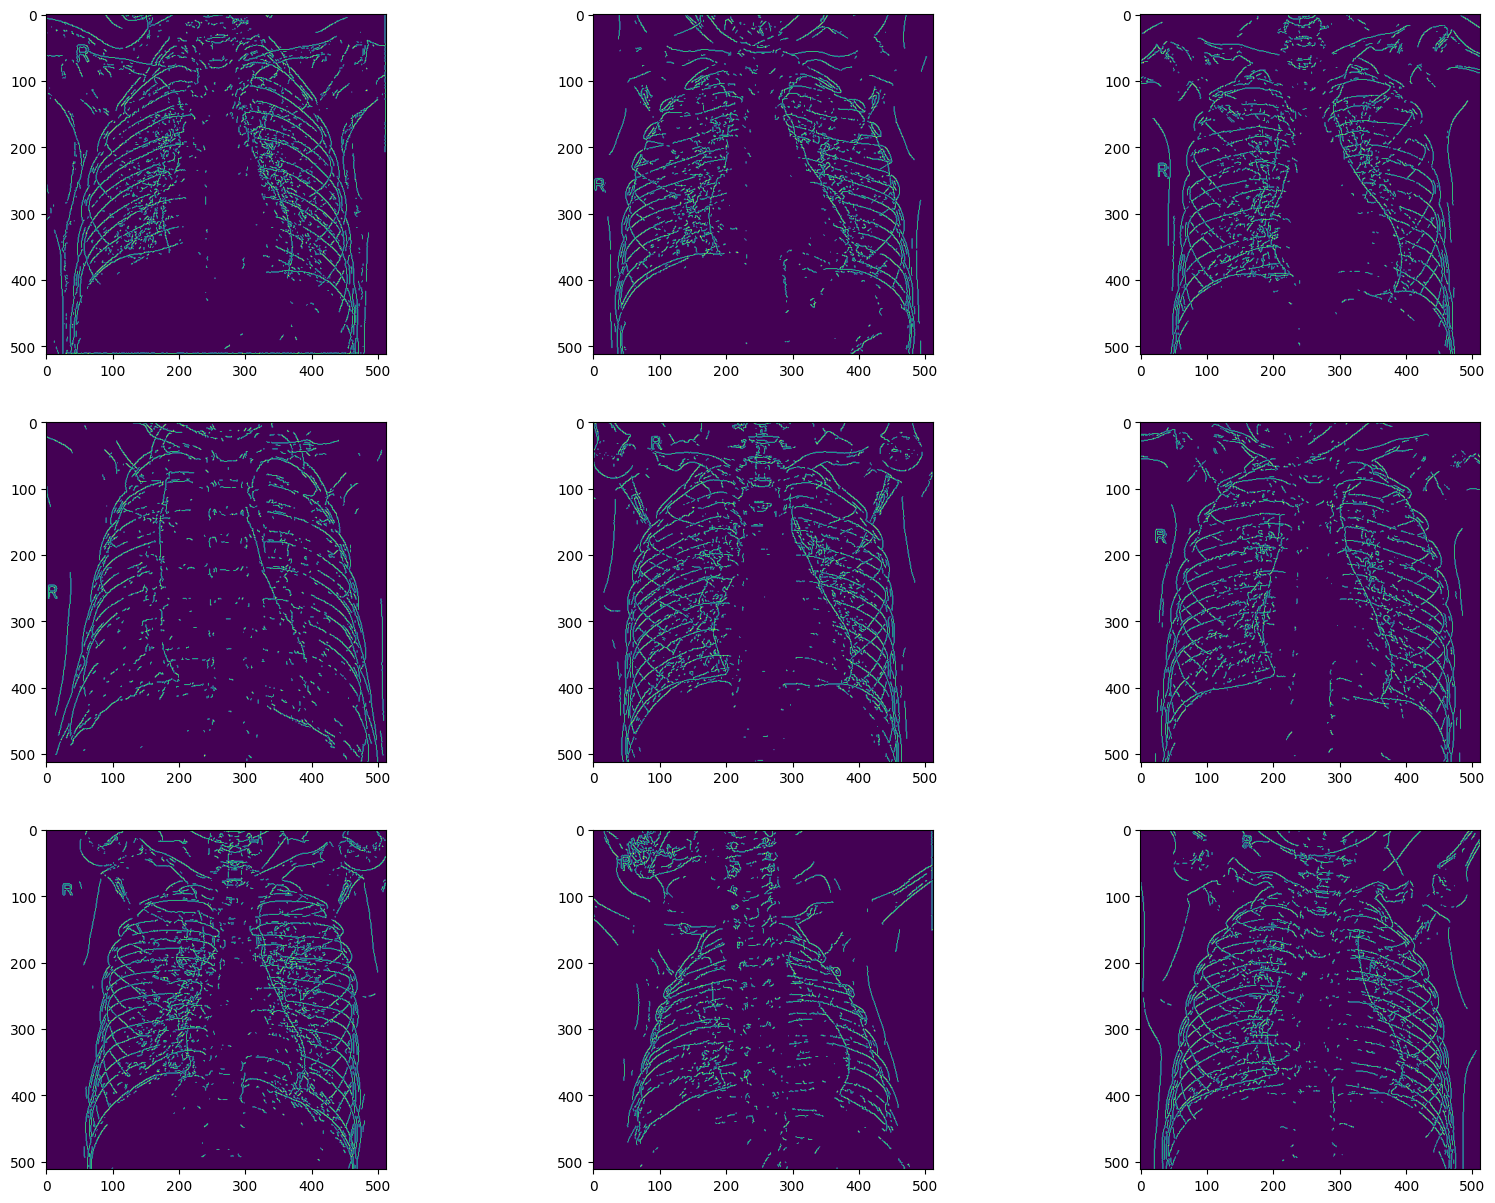

In [16]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Build deep learning models 🔺️</p>

In [17]:
train_dir = "data/train"
test_dir = "data/test"
validation_dir = "data/val"

In [18]:
%%time

train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
CPU times: total: 219 ms
Wall time: 328 ms


#### <span style='background:#4A1810;color:#ffffff;'> Cache and prefetch data </span>


If we use <mark>flow_from_directory along with ImageDataGenerator()</mark> to set up the dataset, it will not be compatible with <mark>tensorflow.data.AUTOTUNE.</mark> Use <mark>tensorflow.keras.preprocessing.image_dataset_from_directory</mark> instead to load the dataset.

In [19]:
'''
AUTOTUNE = tensorflow.data.experimental.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size = AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size = AUTOTUNE)
'''
pass

#### <span style='background:#4A1810;color:#ffffff;'> Build CNN model 🔺️ </span>

## What is a convolutional neural network algorithm?

A convolutional neural network (ConvNet / Convolutional neural networks -CNN) is a deep learning algorithm that can take an input image and separate various aspects/objects in the image. CNN is a network architecture for deep learning that learns directly from data. CNNs are particularly useful for finding patterns in images to recognize objects, classes, and categories. They can also be quite effective for classifying audio, time-series and signal data.

![](https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)


## Convolution layer

A convolutional layer is the main building block of a CNN. It contains a set of filters (or kernels) whose parameters will be learned throughout the training. The size of the filters is usually smaller than the actual image. Each filter intertwines with the image and creates an activation map.

![](https://miro.medium.com/max/1400/1*D6iRfzDkz-sEzyjYoVZ73w.gif)


## Convolutional stride

Stride is a parameter of the neural network's filter that modifies the amount of movement over the image or video.

![](https://csdl-images.ieeecomputer.org/trans/si/2020/04/figures/ko1ab-2961602.gif)


## Convolutional padding

Padding is a term relevant to convolutional neural networks as it refers to the amount of pixels added to an image when it is being processed by the kernel of a CNN. For example, if the padding in a CNN is set to zero, then every pixel value that is added will be of value zero.

What does padding ='same' means? In this case, we add 'p' padding layers such that the output image has the same dimensions as the input image. It is called "same" because the output size is the same as the input size (when stride = 1). Using 'same' ensures that the filter is applied to all the elements of the input. Normally, padding is set to "SAME" while training the model.

![](https://miro.medium.com/max/2000/1*WpOcRWlofm0Z0EDUTKefzg.gif)


## Pooling layer

The purpose of the pooling layers is to reduce the dimensions of the hidden layer by combining the outputs of neuron clusters at the previous layer into a single neuron in the next layer.

![](https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif)

![](https://miro.medium.com/max/1400/1*fXxDBsJ96FKEtMOa9vNgjA.gif)

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">AlexNet model1</p>

In [20]:
model1 = Sequential()

#convolutional neural networks - CNNs
model1.add(Conv2D(32, (3,3), strides = (1, 1),activation = "relu", padding = "same", input_shape = (224, 224, 3)))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(64, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Conv2D(128, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(256, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Flatten())

#fully connected layer
model1.add(Dense(128, activation = "relu"))
model1.add(Dense(64, activation = "relu"))
model1.add(Dense(32, activation = "relu"))
model1.add(Dense(1, activation = "sigmoid"))
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,821,441 (26.02 MB)

 Trainable params: 6,821,441 (26.02 MB)

 Non-trainable params: 0 (0.00 B)

#### <span style='background:#4A1810;color:#ffffff;'> Compile the model </span>

In [21]:
model1.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

#### <span style='background:#4A1810;color:#ffffff;'> Train the model </span>

In [22]:
%%time

early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
%%time

history = model1.fit(train_set, epochs = 10,
                              validation_data = validation_set,
                              steps_per_epoch = 10,
                              callbacks = [early_stopping_callbacks])

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 826ms/step - accuracy: 0.7280 - loss: 0.5501 - val_accuracy: 0.5000 - val_loss: 0.7127
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 762ms/step - accuracy: 0.7899 - loss: 0.4577 - val_accuracy: 0.5000 - val_loss: 0.6327
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 868ms/step - accuracy: 0.7252 - loss: 0.4941 - val_accuracy: 0.5000 - val_loss: 0.7533
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 935ms/step - accuracy: 0.6975 - loss: 0.5472 - val_accuracy: 0.5000 - val_loss: 0.6619
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7197 - loss: 0.4676 - val_accuracy: 0.5000 - val_loss: 0.7497
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7189 - loss: 0.5188 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7680 - loss: 0.4508 - val_accuracy: 0.4375 - val_loss: 0.6733
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7245 - loss: 0.4673 - val_accuracy: 0.4375 - 

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Visualize the performance of model1</p>

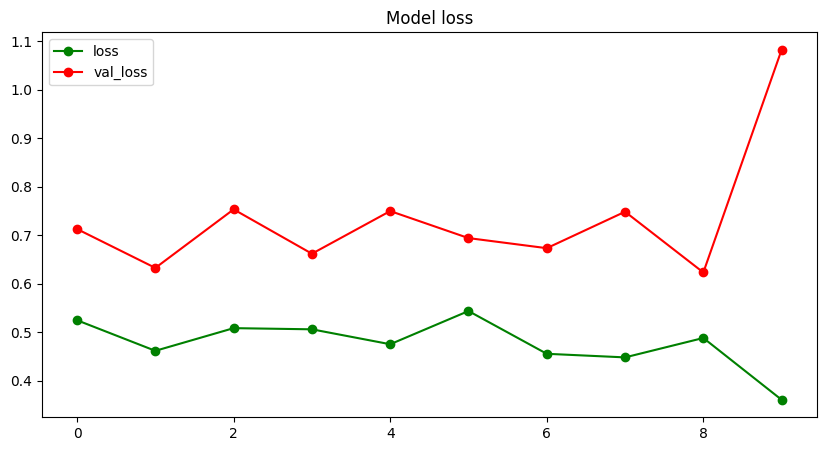

In [29]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

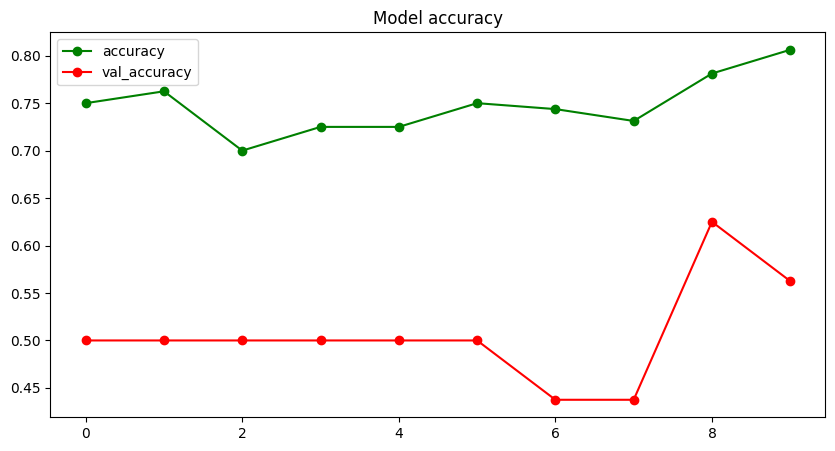

In [30]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")

plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Evaluate model1 on the test set </p>

In [31]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model1.evaluate(test_set, steps = 100)

print("The testing accuracy is: ", test_loss * 100, "%")

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.6499 - loss: 0.5894
The testing accuracy is:  59.648215770721436 %


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">VGG16 model</p>

In [32]:
base_model1 = VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3), pooling = "max",
                    classes = 2)

#base_model1.load_weights("../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")
base_model1.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model2 = Sequential()
model2.add(base_model1)
model2.add(Flatten())

model2.add(Dense(128, activation = "relu"))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model1.layers:
    layer.trainable = False

model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [34]:
%%time

history = model2.fit(train_set, epochs = 10, validation_data = validation_set, steps_per_epoch = 10,
                               callbacks = [early_stopping_callbacks])

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7510 - loss: 0.5812 - val_accuracy: 0.5000 - val_loss: 0.6811
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.6741 - loss: 0.5994 - val_accuracy: 0.5000 - val_loss: 0.7607
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7441 - loss: 0.4752 - val_accuracy: 0.6875 - val_loss: 0.5558
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7840 - loss: 0.3847 - val_accuracy: 0.8125 - val_loss: 0.4285
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8204 - loss: 0.3633 - val_accuracy: 0.8125 - val_loss: 0.4209
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8434 - loss: 0.3505 - val_accuracy: 0.8750 - val_loss: 0.4428
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.8642 - loss: 0.3712 - val_accuracy: 0.8750 - val_loss: 0.3865
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.8999 - loss: 0.2445 - val_accuracy: 0.7500 - val_loss:

### Visualize the performance of model2

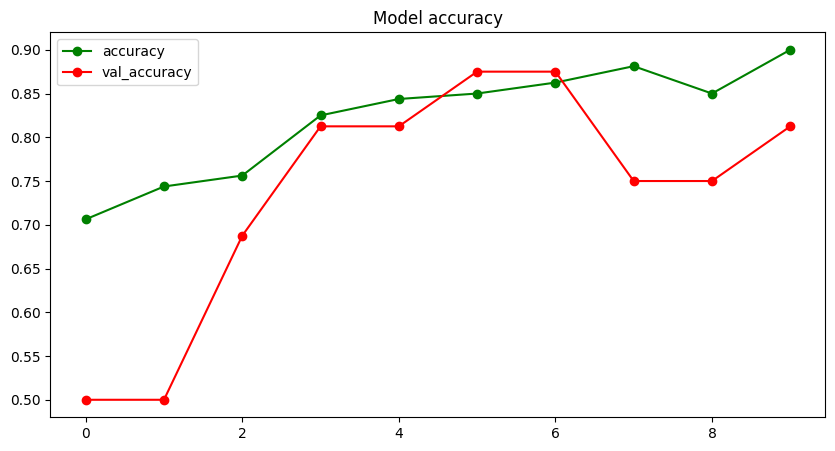

In [35]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

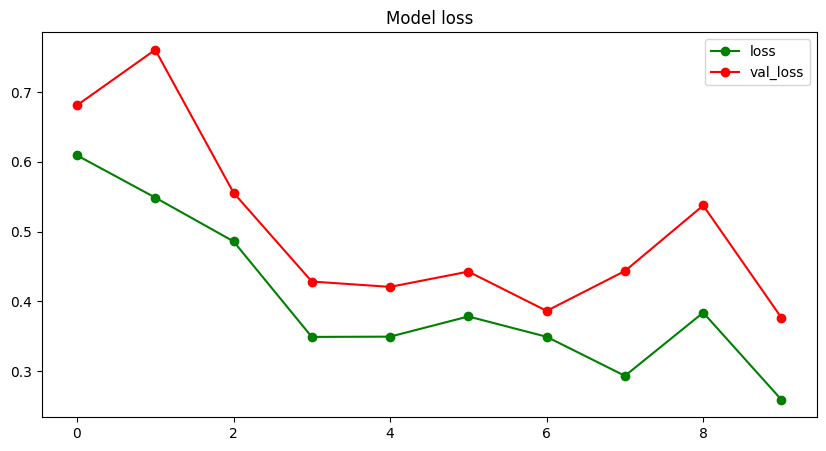

In [36]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

### Evaluate model2 on the test set

In [37]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model2.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.7122 - loss: 0.5196
The testing accuracy is:  69.55128312110901 %
The testing loss is:  53.31757664680481 %


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">ResNet50V2 model</p>

In [38]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (224, 224, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model2.layers:
    layer.trainable = False
    
base_model2.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 56, 56, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 56, 56, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 58, 58, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [39]:
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])



In [40]:
%%time

history = model3.fit(train_set, epochs = 10, validation_data = validation_set, steps_per_epoch = 10,
                              callbacks = [early_stopping_callbacks])

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5728 - loss: 1.7561 - val_accuracy: 0.5000 - val_loss: 1.5787
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7358 - loss: 0.6226 - val_accuracy: 0.5000 - val_loss: 1.3835
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8076 - loss: 0.4675 - val_accuracy: 0.6250 - val_loss: 0.7542
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7651 - loss: 0.4073 - val_accuracy: 0.6250 - val_loss: 0.9033
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8181 - loss: 0.4361 - val_accuracy: 0.6875 - val_loss: 0.5459
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8373 - loss: 0.3850 - val_accuracy: 0.6875 - val_loss: 0.9090
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8452 - loss: 0.3418 - val_accuracy: 0.8125 - val_loss: 0.4876
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8873 - loss: 0.2135 - val_accuracy: 0.8750 - val_loss:

### Visualize performance of model3

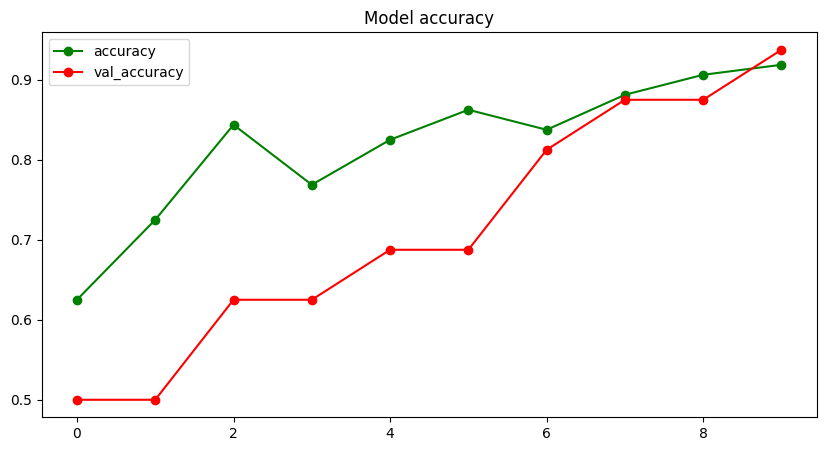

In [41]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

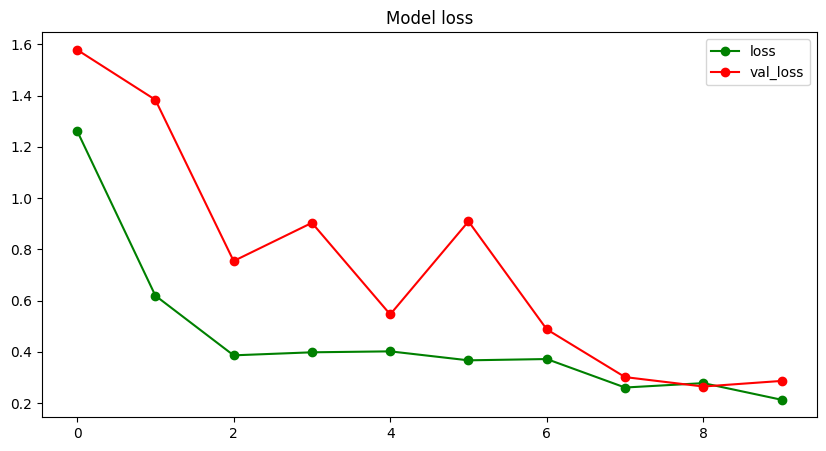

In [42]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

### Evaluate model3 on the test set

In [43]:
test_loss, test_accuracy = model3.evaluate(test_set, steps = 100)
print("The testing accuracy is: ", test_accuracy * 100, "%")


100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 319ms/step - accuracy: 0.8101 - loss: 0.4449
The testing accuracy is:  80.60897588729858 %


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4A1810; font-family:sans-serif;color:#FFFFFF;font-size:130%;text-align:center;border-radius:55px 1px;">Prediction of a new image </p>

In [44]:
%%time

new_image_path = "data/train/PNEUMONIA/person11_bacteria_45.jpeg"
test_image = image.load_img(new_image_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
#test_image = np.reshape(test_image, (1, 224, 224, 3))
test_image = test_image / 255

#___________________________________________________________________

result = model3.predict(test_image)
train_set.class_indices
if result[0][0] == 0:
    prediction = "N O R M A L"
else:
    prediction = "P N E U M O N I A"

print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
P N E U M O N I A
CPU times: total: 1.53 s
Wall time: 1.7 s


### Save the model to disk

In [45]:
model3.save("model.h5")
print(colored("Model3 was succesfully saved to disk...", color = "green", attrs = ["bold", "dark"]))

Model3 was succesfully saved to disk...


### Some time later you may need that model to use

In [46]:
model_loaded = tensorflow.keras.models.load_model("trained_model.h5")
model_loaded.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 2048)                │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,837,443 (90.93 MB)

 Trainable params: 272,641 (1.04 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 2 (12.00 B)

### Use loaded model to predict new image

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
This image is 83.522 percent N O R M A L


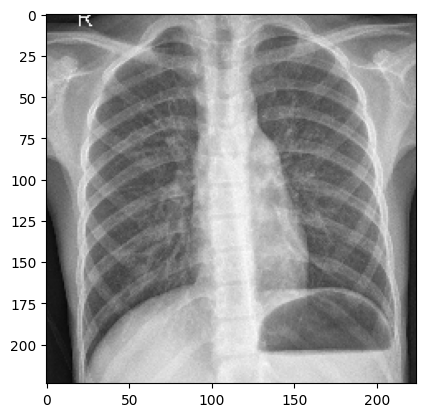

In [47]:
def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    #test_image = np.reshape(test_image, (224, 224, 3))
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image / 255.0
    model_loaded = tensorflow.keras.models.load_model("trained_model.h5")
    prediction = model_loaded.predict(test_image)
    test_image_for_plotting = image.load_img(new_image_path, target_size = (224, 224))
    plt.imshow(test_image_for_plotting)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100 
        print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))
     
 
# call and use the function
image_prediction("data/test/NORMAL/IM-0033-0001.jpeg")

### Get test data and test labels

In [48]:
test_dir = "data/test"
test_data, test_labels = [], []

In [49]:
for i in ["/NORMAL/", "/PNEUMONIA/"]:
    for image in (os.listdir(test_dir + i)):
        image = plt.imread(test_dir + i + image)
        image = cv2.resize(image, (224, 224))
        image = np.dstack([image, image, image])
        image = image.astype("float32") / 255
        if i == "/NORMAL/":
            label = 0
        elif i == "/PNEUMONIA/":
            label = 1
        test_data.append(image)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

### Plot confusion matrix

_______C o n f u s i o n   m a t r i x_______

20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step


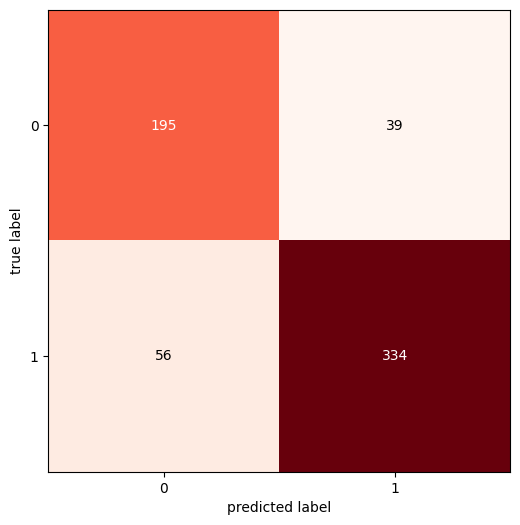

In [50]:
print("_______C o n f u s i o n   m a t r i x_______\n")

predictions = model_loaded.predict(test_data)
conf_m = confusion_matrix(test_labels, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = matplotlib.pyplot.cm.Reds)
plt.show()